## Basic Imports

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shutil
import glob
from pathlib import Path
import random
import json
%matplotlib inline

from PIL import Image
import io

import cv2

import torch
import torch.nn.functional as F
from torch import optim, nn, utils, Tensor
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.utils.data.dataset import random_split
from torchvision.datasets import ImageFolder

import torchvision
from torchvision.datasets import MNIST, CIFAR10

from torchvision import transforms
from torchvision.transforms import Compose, ToTensor, Resize, Normalize
from torchvision.models import resnet18, ResNet18_Weights

import torchmetrics

import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.loggers import CSVLogger

from datasets import load_dataset

from typing import Callable, Optional, List, Dict

from transformers import DonutProcessor, VisionEncoderDecoderModel, get_cosine_schedule_with_warmup

import evaluate

# Configure device (GPU if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")
else:
    print("No GPU available, using CPU")

/Users/paul_araque/Desktop/Carrera/Septimo Semestre/Segundo Periodo/Reto/Reto_BloqueIA-final/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu
No GPU available, using CPU


## Load CORD-v2 Dataset

In [2]:
# Load CORD-v2 dataset
print("Loading CORD-v2 dataset from Hugging Face:")
ds = load_dataset("naver-clova-ix/cord-v2")

print("Dataset loaded successfully!")
print("Dataset structure:")
print(ds)

# Show dataset splits
print("Available splits:")
for split in ds.keys():
    print(f"    - {split}: {len(ds[split])} samples")

Loading CORD-v2 dataset from Hugging Face:
Dataset loaded successfully!
Dataset structure:
DatasetDict({
    train: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 800
    })
    validation: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 100
    })
    test: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 100
    })
})
Available splits:
    - train: 800 samples
    - validation: 100 samples
    - test: 100 samples
Dataset loaded successfully!
Dataset structure:
DatasetDict({
    train: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 800
    })
    validation: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 100
    })
    test: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 100
    })
})
Available splits:
    - train: 800 samples
    - validation: 100 samples
    - test: 100 samples


## Custom Transform Classes

Define preprocessing transforms used in the training pipeline. See Dataset_Study.ipynb for more information and details.

In [3]:
class CLAHETransform:
    """Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)."""
    
    def __init__(self, clip_limit=2.0, tile_grid_size=(8, 8)):
        self.clip_limit = clip_limit
        self.tile_grid_size = tile_grid_size
    
    def __call__(self, img):
        """
        Args:
            img: PIL Image
        Returns:
            PIL Image after CLAHE
        """
        img_np = np.array(img)
        
        if len(img_np.shape) == 3:
            gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
        else:
            gray = img_np
        
        clahe = cv2.createCLAHE(clipLimit=self.clip_limit, tileGridSize=self.tile_grid_size)
        clahe_img = clahe.apply(gray)
        
        if len(img_np.shape) == 3:
            clahe_img = cv2.cvtColor(clahe_img, cv2.COLOR_GRAY2RGB)
        
        return Image.fromarray(clahe_img)


class SharpenTransform:
    """Apply sharpening filter to enhance text edges."""
    
    def __init__(self, amount=1.0):
        self.amount = amount
    
    def __call__(self, img):
        """
        Args:
            img: PIL Image
        Returns:
            PIL Image after sharpening
        """
        img_np = np.array(img)
        
        kernel = np.array([
            [0, -1, 0],
            [-1, 5, -1],
            [0, -1, 0]
        ]) * self.amount
        
        if len(img_np.shape) == 3:
            sharpened = cv2.filter2D(img_np, -1, kernel)
        else:
            sharpened = cv2.filter2D(img_np, -1, kernel)
        
        return Image.fromarray(sharpened)


# Initialize transform instances
clahe_transform = CLAHETransform(clip_limit=2.0, tile_grid_size=(8, 8))
sharpen_transform = SharpenTransform(amount=1.0)

print("Custom transforms defined successfully")

Custom transforms defined successfully


# Donut: Document Understanding Transformer for Structured Receipt Information Extraction
---
Donut (Document Understanding Transformer) is a vision-language model that specialized in extracting structured JSON outputs containing key-value pairs, which makes it good for parsing receipts into organized data formats. It direclty converts documents images into structured text, eliminating any kind of errors that might occur during the pipeline process on other systems. Extracting structured information from receipts is very challenging because they can have different layouts with different store formats and receipt designs, as well as other information, such as sotre details, items with prices, subtotals, and totals. Also, the model to extract the text needs to understand semantic differences that distinguishes between similar numbers, like item price vs total, missing fields, formatting variations, and more. Because of all this, using Donut is beneficial, since:
- It is pre-trained on large-scale documents, which gives the ability to understand document structure from millions of images.
- Generated structured JSON output directly, which is perfect for dtatabase storage and downstream applications.
- It contains multi-modal understanding that combines visual layout and text semantics.
- We can apply transfer learning to leverage knowledge from divese document types.

Donut follows an encoder-decoder architecture where:

1. **Encoder: Swin Transformer**:
    - **Input**: Receipt as RGB image and resized to fixed dimensions.
    - **Process**: The image is divided into patches using windows and creating multi-scale feature representations
    - **Output**: Sequence of visual embeddings representing document structure and content
    - **Pre-trained on**: ImageNet-22K and document images
    - **What it does**: It extracts visual features, while preserving spatial relationships and hierarchical document structure
2. **Decoder: mBART (Multilingual BART)**:
    - **Input**: Visual embeddings from encoder and task prompt `<s_cord-v2>`
    - **Process**: Generates JSON tokens autoregressively, which means one character at a time
    - **Output**: Structured JSON string containing receipt information
    - **Pre-trained on**: Large multilingual text corpora
    - **What it does**: Converts visual features into structured JSON using sequence-to-sequence generation. It is very robust to receipt variations, such as different layouts, fonts, and quality.
    - It uses mBART since it has a strong multilingual capabilities and can handle various receipt languages, robust JSON generation trained on structured text formats, and contextual understanding to maintain valid JSON structure throughout generation. It also gives a high accuracy on structured information extraction
3. **Cross-Attention Mechanism**: the decoder attends to encoder outputs at each generation step, and applying fine-tuning allows us to: 
    - Focus on specific document regions when generating each JSON key-value pair
    - Align visual features with semantic labels. An alternative is to use `naver-clova-ix/donut-base-finetuned-cord-v2`, which is already fine-tuned on CORD-v2, but we want to compare our custom fine-tuning strategies.
    - Handle variable document layouts and field positions

In the following steps, we are going to implement three fine-tuning strategies to adapt the pre-trained Donut model to receipt parsing:
1. **Strategy 1: Frozen Encoder (Feature Extraction)**:
    - **Freeze**: All encoder layers (Swin Transformer)
    - **Train**: Only decoder layers (mBART)
    - **Reason**: The encoder already knows how to extract visual features from documents, since it is pre-trained on document images. We only need to adapt the decoder to receipt-specific JSON structure and vocabulary.
    - **Advantages**: Fast training, low memory usage, less chance of overfitting
    - **Disadvantages**: Limited adaptation to receipt-specific visual patterns, such as thermal printing artifacts and variable quality.
    - **Best for**: Small datasets and limited compute resources (Our dataset has 1000 receipts).

2. **Strategy 2: Partial Unfreezing (Progressive Fine-Tuning)**:
    - **Freeze**: First N-2 encoder layers
    - **Train**: Last 2 encoder layers, as well as all decoder layers
    - **Reason**: Lower Swin Transformer layers learn generic features, like edges and windows, while higher layers learn task-specific patterns. By unfreezing the last 2 layers, we allow the model to adapt to receipt-specific visual characteristics like tables and text regions.
    - **Advantages**: Better domain adaptation than frozen encoder
    - **Disadvantages**: Requires more memory and compute than Strategy 1
    - **Best for**: Medium-sized datasets with some computational budget

3. **Strategy 3: Full Fine-Tuning (End-to-End Training)**:
    - **Freeze**: Nothing
    - **Train**: All encoder and decoder layers
    - **Reason**: Maximum adaptation to receipts. The model can learn receipt-specific visual features and JSON generation patterns simultaneously.
    - **Advantages**: Best performance potential, due to full customization
    - **Disadvantages**: Requires large dataset, high memory and compute, but has risk of overfitting
    - **Best for**: Large datasets and sufficient compute

## Donut Dataset Preparation

As we mentioned before, Donut is trained to perform structured information extraction from document images.
- **Input**: Receipt image (PIL Image)
- **Output**: Structured JSON string (key-value pairs representing receipt fields)
- **Error handling**: If JSON parsing fails, return empty JSON object to prevent training crashes.

**CORD-v2 Dataset Structure**:

The CORD-v2 dataset provides:
- **Images**: Receipt images in PNG format
- **Ground truth**: JSON annotations with:
  - `valid_line`: List of text lines in the receipt
  - `words`: Individual words with bounding boxes and text content
  - `category`: Semantic labels (menu.nm, menu.price, total.total_price, etc.)

**Data Extraction Process**:

We need to convert the structured JSON annotations into a format suitable for Donut's sequence-to-sequence generation. To achieve this, we will follow these steps:
1. **Parse JSON**: Load the `ground_truth` string and parse it as JSON
2. **Extract structured fields**: Iterate through `valid_line` and `words` to collect all text
3. **Create JSON output**: Package extracted information as a JSON string with key-value pairs
4. **Add task prompt**: Prepend `<s_cord-v2>` token to guide the decoder
5. **Example**:
   - Input JSON: `{"valid_line": [{"words": [{"text": "TOTAL"}, {"text": "$45.99"}]}]}`
   - Output sequence: `<s_cord-v2>{"text": "TOTAL $45.99"}</s>`

**Preprocessing Pipeline**:

For each image, we will:
1. Apply minimal ColorJitter for little augmentation to avoid aggressive transforms that hurt OCR.
2. Use Donut processor to handle resizing, normalization, and conversion to tensors internally.
3. Apply tokenization to convert JSON strings into token IDs using mBART tokenizer.
4. Apply padding or truncation of sequences to a `max_length` of 512 tokens.

Some special cases include:
- **Task prompt**: `<s_cord-v2>` is added as a special token to signal receipt parsing task
- **Padding tokens**: Replaced with `-100` in labels so they're ignored during loss computation
- **Max length**: Set to 512 tokens to accommodate structured JSON while fitting in GPU memory

The following class is created to combine CORD's structured annotations and Donut's expected input and output formats.

In [4]:
class DonutDataset(Dataset):
    """
    Extracts structured information (JSON) from receipt images.
    """
    def __init__(
        self,
        hf_dataset,
        processor,
        image_transform: Optional[Callable] = None,
        max_length: int = 512,
        task_prompt: str = "<s_cord-v2>",
    ):
        self.hf_dataset = hf_dataset
        self.processor = processor
        self.image_transform = image_transform
        self.max_length = max_length
        self.task_prompt = task_prompt
        
        # Add special tokens to processor
        self.processor.tokenizer.add_special_tokens({"additional_special_tokens": [task_prompt]})
        
        print(f"DonutDataset initialized with {len(self.hf_dataset)} samples")
    
    def __len__(self) -> int:
        return len(self.hf_dataset)
    
    def extract_structured_info(self, ground_truth_str: str) -> str:
        """
        Extract structured information from CORD ground truth.
        Returns a JSON string with key-value pairs.
        """
        try:
            gt_dict = json.loads(ground_truth_str)
            
            # Extract relevant fields from CORD dataset
            structured_data = {}
            
            if 'valid_line' in gt_dict:
                all_text = []
                for line in gt_dict['valid_line']:
                    if 'words' in line:
                        line_text = []
                        for word in line['words']:
                            if 'text' in word:
                                line_text.append(word['text'])
                        if line_text:
                            all_text.append(' '.join(line_text))
                
                structured_data['text'] = ' '.join(all_text)
            
            return json.dumps(structured_data, ensure_ascii=False)
        except:
            return json.dumps({"text": ""})
    
    def __getitem__(self, idx: int) -> Dict[str, torch.Tensor]:
        sample = self.hf_dataset[idx]
        
        # Get image
        image = sample['image']
        
        # Apply custom preprocessing
        if self.image_transform:
            image = self.image_transform(image)
        
        # Extract structured information
        structured_json = self.extract_structured_info(sample['ground_truth'])
        
        # Create target sequence: <s_cord-v2> + JSON + </s>
        target_sequence = f"{self.task_prompt}{structured_json}</s>"
        
        # Process image
        pixel_values = self.processor(image, return_tensors="pt").pixel_values.squeeze()
        
        # Tokenize target sequence
        labels = self.processor.tokenizer(
            target_sequence,
            add_special_tokens=False,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        ).input_ids.squeeze()
        
        # Replace padding token id with -100
        labels[labels == self.processor.tokenizer.pad_token_id] = -100
        
        return {
            "pixel_values": pixel_values,
            "labels": labels,
            "target_sequence": target_sequence,
        }

# Test Donut dataset
print("Loading Donut processor:")
donut_processor = DonutProcessor.from_pretrained("naver-clova-ix/donut-base")

# The Donut processor handles conversion to tensor and normalization internally, so we only apply minimal ColorJitter
donut_preprocess = transforms.Compose([
    transforms.ColorJitter(brightness=0.05, contrast=0.05),
])

# Create test dataset
donut_test_dataset = DonutDataset(
    hf_dataset=ds['train'],
    processor=donut_processor,
    image_transform=donut_preprocess,
    max_length=512,
)

# Test sample
test_sample = donut_test_dataset[0]
print(f"Sample output:")
print(f"    - Pixel values shape: {test_sample['pixel_values'].shape}")
print(f"    - Labels shape: {test_sample['labels'].shape}")
print(f"    - Target sequence preview: {test_sample['target_sequence'][:150]}...")
print(f"Donut Dataset ready!")

Loading Donut processor:


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


DonutDataset initialized with 800 samples
Sample output:
    - Pixel values shape: torch.Size([3, 2560, 1920])
    - Labels shape: torch.Size([512])
    - Target sequence preview: <s_cord-v2>{"text": "1 x Nasi Campur Bali 75,000 1 x Bbk Bengil Nasi 125,000 1 x MilkShake Starwb 37,000 1 x Ice Lemon Tea 24,000 1 x Nasi Ayam Dewata...
Donut Dataset ready!
Sample output:
    - Pixel values shape: torch.Size([3, 2560, 1920])
    - Labels shape: torch.Size([512])
    - Target sequence preview: <s_cord-v2>{"text": "1 x Nasi Campur Bali 75,000 1 x Bbk Bengil Nasi 125,000 1 x MilkShake Starwb 37,000 1 x Ice Lemon Tea 24,000 1 x Nasi Ayam Dewata...
Donut Dataset ready!


## Donut Model Implementation with PyTorch Lightning

We will use PyTorch Lightning for the same reasons as TrOCR:
- **Organized code**: Separates research code from engineering code
- **Built-in features**: Automatic logging, checkpointing, early stopping, multi-GPU support
- **Reproducibility**: Handles random seeds, deterministic training
- **Less boilerplate**: No need to manually write training loops, GPU transfer logic

**Model Class Structure**: The following implementation of our `DonutLightningModel` inherits from `LightningModule` and implements:
1. Initialization (`__init__`):
    - Load pre-trained `VisionEncoderDecoderModel` (Swin + mBART) from Hugging Face
    - Load corresponding `DonutProcessor` to handle image preprocessing and tokenization.
    - Add task-specific token `<s_cord-v2>` to vocabulary and resize decoder embeddings
    - Configure generation parameters, like start token, padding, and EOS token.
    - Apply freezing strategy (freeze/unfreeze layers based on strategy)
    - Initialize metrics: token-level accuracy
2. Freezing Strategy (`_apply_freezing_strategy`):
    - Iterate through `model.encoder.parameters()` and set `requires_grad = False` to freeze
    - For partial unfreezing: Access Swin layers via `model.encoder.encoder.layers[-N:]` and unfreeze
    - Decoder is always trainable: `model.decoder.parameters()` have `requires_grad = True`
    - We freeze parameters, since those don't compute gradients, which is equivalent to faster training and less memory. Also, pre-trained weights are preserved and only task-specific layers adapt for better generalization on small datasets.
3. Forward Pass (`forward`):
    - Takes `pixel_values` (image tensors) and `labels` (JSON token IDs)
    - Returns model outputs including loss and logits
    - Loss is automatically computed by comparing logits with labels (cross-entropy)
4. Training Step (`training_step`):
    - This is what happens in each training iteration:
        1. Forward pass: `outputs = self(pixel_values, labels=labels)`
        2. Extract loss: `loss = outputs.loss`
        3. Compute token-level accuracy from logits (no generation during training for efficiency)
        4. Log metrics: `self.log('train_loss', loss)`, `self.log('train_acc', self.train_acc)`
        5. Return loss (Lightning automatically calls `loss.backward()` and optimizer step)
    - Computing accuracy from logits is much faster than generating full JSON sequences
5. Validation Step (`validation_step`):
    - Evaluate model on validation set to monitor overfitting
        1. Forward pass, same as training.
        2. Compute token-level accuracy from logits
        3. Log metrics: `self.log('val_loss', loss)`, `self.log('val_acc', self.val_acc)`
    - No JSON generation during validation for speed (only during test)
6. Test Step (`test_step`):
    - Generate full JSON sequences for qualitative evaluation
        1. Forward pass for loss and accuracy
        2. Generate predictions: `model.generate(pixel_values, max_length=512)`
        3. Decode predictions to JSON strings
        4. Compute token-level accuracy
        5. Log metrics and return predictions for analysis
7. Optimizer Configuration (`configure_optimizers`)
    - AdamW Optimizer:
        - Variant of Adam with decoupled weight decay to prevent overfitting
        - Learning rate: 5e-5, which is commonly used for fine-tuning document understanding models
        - Weight decay: 0.01, which is L2 regularization.
    - Cosine Annealing with Warmup:
        - Gradually increases LR during warmup (500 steps)
        - Then decreases following cosine schedule
        - Helps model converge smoothly and avoid early training instability

Some key variables are:
1. `max_length=512`: limit inference time and memory usage while accommodating structured JSON outputs. We decided on 512, since JSON outputs are typically longer than plain text.
2. We replace padding with `-100` in labels, since PyTorch's `CrossEntropyLoss` ignores index `-100`, which ensures padding tokens don't contribute to loss and prevents the model from learning to predict padding.
3. We have log metrics with `prog_bar=True` to display metrics in real-time during training, which helps us monitor training progress.
4. `<s_cord-v2>` task prompt: guides the decoder to generate receipt-specific JSON structure

In [5]:
class DonutLightningModel(L.LightningModule):
    """
    Donut model with PyTorch Lightning for document understanding.
    
    Fine-tuning strategy:
    - Strategy 1: Freeze encoder, train decoder only
    - Strategy 2: Unfreeze last 2 encoder layers + decoder
    - Strategy 3: Full fine-tuning
    """
    def __init__(
        self,
        model_name: str = "naver-clova-ix/donut-base",
        learning_rate: float = 5e-5,
        warmup_steps: int = 500,
        freeze_encoder: bool = True,
        unfreeze_last_n_layers: int = 0,
        max_length: int = 512,
    ):
        super().__init__()
        self.save_hyperparameters()
        
        # Load pre-trained Donut model
        self.model = VisionEncoderDecoderModel.from_pretrained(model_name)
        self.processor = DonutProcessor.from_pretrained(model_name)
        
        # Add task-specific token
        self.processor.tokenizer.add_special_tokens({"additional_special_tokens": ["<s_cord-v2>"]})
        self.model.decoder.resize_token_embeddings(len(self.processor.tokenizer))
        
        # Apply freezing strategy
        self._apply_freezing_strategy(freeze_encoder, unfreeze_last_n_layers)
        
        # Configure generation parameters
        self.model.config.decoder_start_token_id = self.processor.tokenizer.convert_tokens_to_ids(["<s_cord-v2>"])[0]
        self.model.config.pad_token_id = self.processor.tokenizer.pad_token_id
        self.model.config.eos_token_id = self.processor.tokenizer.eos_token_id
        
        # Metrics: Token-level accuracy, multiclass with ignore_index for padding
        vocab_size = len(self.processor.tokenizer)
        self.train_acc = torchmetrics.Accuracy(
            task="multiclass",
            num_classes=vocab_size,
            ignore_index=-100
        )
        self.val_acc = torchmetrics.Accuracy(
            task="multiclass",
            num_classes=vocab_size,
            ignore_index=-100
        )
        
    def _apply_freezing_strategy(self, freeze_encoder: bool, unfreeze_last_n_layers: int):
        """
        Apply layer freezing, based on the strategy selected
        """
        if freeze_encoder:
            # Freeze all encoder parameters
            for param in self.model.encoder.parameters():
                param.requires_grad = False
            print("Encoder (Swin Transformer) frozen")
            
            # Unfreeze last N layers if specified
            if unfreeze_last_n_layers > 0:
                # Access Swin Transformer layers
                try:
                    encoder_layers = self.model.encoder.encoder.layers
                    for layer in encoder_layers[-unfreeze_last_n_layers:]:
                        for param in layer.parameters():
                            param.requires_grad = True
                    print(f"Unfroze last {unfreeze_last_n_layers} encoder layers")
                except Exception as e:
                    print(f"Could not unfreeze specific layers: {e}")
        else:
            print("Encoder unfrozen (full fine-tuning mode)")
        
        # Decoder is always trainable
        for param in self.model.decoder.parameters():
            param.requires_grad = True
        print("Decoder (mBART) trainable")
        
        # Count trainable parameters
        total_params = sum(p.numel() for p in self.model.parameters())
        trainable_params = sum(p.numel() for p in self.model.parameters() if p.requires_grad)
        print(f"Trainable parameters: {trainable_params:,} / {total_params:,} "
              f"({100 * trainable_params / total_params:.2f}%)")
    
    def forward(self, pixel_values, labels=None):
        return self.model(pixel_values=pixel_values, labels=labels)
    
    def training_step(self, batch, batch_idx):
        pixel_values = batch['pixel_values']
        labels = batch['labels']
        
        outputs = self(pixel_values, labels=labels)
        loss = outputs.loss
        
        # Calculate token-level accuracy
        with torch.no_grad():
            logits = outputs.logits
            preds = torch.argmax(logits, dim=-1)
            preds_flat = preds.view(-1)
            labels_flat = labels.view(-1)
            self.train_acc(preds_flat, labels_flat)
        
        self.log('train_loss', loss, prog_bar=True, on_step=True, on_epoch=True)
        self.log('train_acc', self.train_acc, prog_bar=True, on_step=False, on_epoch=True)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        pixel_values = batch['pixel_values']
        labels = batch['labels']
        
        outputs = self(pixel_values, labels=labels)
        loss = outputs.loss
        
        # Calculate token-level accuracy
        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1)
        preds_flat = preds.view(-1)
        labels_flat = labels.view(-1)
        self.val_acc(preds_flat, labels_flat)
        
        self.log('val_loss', loss, prog_bar=True, on_epoch=True)
        self.log('val_acc', self.val_acc, prog_bar=True, on_epoch=True)
        
        return loss
    
    def test_step(self, batch, batch_idx):
        pixel_values = batch['pixel_values']
        labels = batch['labels']
        
        outputs = self(pixel_values, labels=labels)
        
        # Generate predictions
        generated_ids = self.model.generate(
            pixel_values,
            max_length=self.hparams.max_length,
            early_stopping=True,
            pad_token_id=self.processor.tokenizer.pad_token_id,
            eos_token_id=self.processor.tokenizer.eos_token_id,
        )
        generated_texts = self.processor.batch_decode(generated_ids, skip_special_tokens=True)
        
        # Calculate token-level accuracy
        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1)
        preds_flat = preds.view(-1)
        labels_flat = labels.view(-1)
        
        test_acc = torchmetrics.Accuracy(
            task="multiclass",
            num_classes=len(self.processor.tokenizer),
            ignore_index=-100
        ).to(self.device)
        acc = test_acc(preds_flat, labels_flat)
        
        self.log('test_acc', acc, prog_bar=True)
        
        return {'predictions': generated_texts, 'test_acc': acc}
    
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(
            self.parameters(),
            lr=self.hparams.learning_rate,
            betas=(0.9, 0.999),
            eps=1e-8,
            weight_decay=0.01
        )
        
        scheduler = get_cosine_schedule_with_warmup(
            optimizer,
            num_warmup_steps=self.hparams.warmup_steps,
            num_training_steps=self.trainer.estimated_stepping_batches
        )
        
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'interval': 'step'
            }
        }

print("Donut Lightning Model defined successfully")

Donut Lightning Model defined successfully


## Donut DataModule with Custom Preprocessing

Now, we will implement a `LightningDataModule` to encapsulate all data-related logic in one place, such as:
- Dataset creation (train/val/test splits)
- Data transformations and augmentations
- DataLoader configuration, like batch size, shuffling and workers.
- Reproducibility to ensure consistent data handling across experiments.

Instead of relying only on Donut processor, we use minimal custom preprocessing:
- We first tried with CLAHE and Sharpen transformations, but we were not getting good results, and after analyzing we decided to remove those transformations and only use ColorJitter.
- **Minimal ColorJitter**: little brightness and contrast adjustments to avoid aggressive transforms that hurt OCR performance.
- Applying minimal augmentation is very important because it slightly increases dataset diversity without introducing artifacts. Then, using Donut Processor helps us resize, normalize and convert to tensor with the purpose of preparing for model input.

**Augmentation Strategy**: 
- Training step: we will apply minimal augmentations to slightly increase dataset diversity.
    - Color jitter with 0.05 brightness and contrast to simulate little lightning variations.
    - No rotation or geometric transforms, since these can hurt document understanding performance.
- Validation and Test sets: no augmentation, only processor normalization.
    - We want to measure true performance on clean processed images.
    - Augmentation during validation would give misleading metrics.

**DataLoader Configuration**:
- **Batch size**: Set to 4 for frozen and partial strategies, 3 for full
- **Shuffle**: True for training for random order, but False for validation and test
- **num_workers**: Set to 4 for parallel data loading
- **pin_memory**: True for faster CPU-to-GPU transfer
- **persistent_workers**: True to reuse workers between epochs
- **collate_fn**: Custom function to properly batch mixed data types (tensors and JSON strings)


**Collate Function Explained**: The main issue is that PyTorch's default collate can't handle mixed types like tensors and list of strings. For this, we created a custom collate function that:
1. Stacks `pixel_values` tensors into batch: `torch.stack([item['pixel_values'] for item in batch])`
2. Stacks `labels` tensors into batch: `torch.stack([item['labels'] for item in batch])`
3. Keeps target_sequence as list: `[item['target_sequence'] for item in batch]` (used for debugging and analysis)

This will ensure us proper batching, while preserving JSON references for analysis and evaluation.

In [6]:
class DonutDataModule(L.LightningDataModule):
    """DataModule for Donut training with CORD-v2 dataset."""
    def __init__(
        self,
        hf_dataset,
        processor,
        batch_size: int = 4,
        num_workers: int = 4,
        max_length: int = 512,
        use_augmentation: bool = True,
    ):
        super().__init__()
        self.hf_dataset = hf_dataset
        self.processor = processor
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.max_length = max_length
        self.use_augmentation = use_augmentation
        
        # Minimal augmentation for OCR
        if use_augmentation:
            self.train_transform = transforms.Compose([
                transforms.ColorJitter(brightness=0.05, contrast=0.05),
            ])
        else:
            self.train_transform = None
        
        self.val_transform = None
    
    def setup(self, stage: str = None):
        self.train_dataset = DonutDataset(
            hf_dataset=self.hf_dataset['train'],
            processor=self.processor,
            image_transform=self.train_transform,
            max_length=self.max_length,
        )
        
        self.val_dataset = DonutDataset(
            hf_dataset=self.hf_dataset['validation'],
            processor=self.processor,
            image_transform=self.val_transform,
            max_length=self.max_length,
        )
        
        self.test_dataset = DonutDataset(
            hf_dataset=self.hf_dataset['test'],
            processor=self.processor,
            image_transform=self.val_transform,
            max_length=self.max_length,
        )
        
        print(f"[DonutDataModule] Train: {len(self.train_dataset)}, "
              f"Val: {len(self.val_dataset)}, Test: {len(self.test_dataset)}")
    
    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
            pin_memory=True,
            persistent_workers=True if self.num_workers > 0 else False,
            collate_fn=self.collate_fn,
        )
    
    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=True,
            persistent_workers=True if self.num_workers > 0 else False,
            collate_fn=self.collate_fn,
        )
    
    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=True,
            collate_fn=self.collate_fn,
        )
    
    @staticmethod
    def collate_fn(batch):
        """
        Custom collate function to handle batching.
        
        This is necessary to properly batch mixed data types: tensors (pixel_values, labels) 
        are stacked, while text strings are kept as a list.
        """
        pixel_values = torch.stack([item['pixel_values'] for item in batch])
        labels = torch.stack([item['labels'] for item in batch])
        target_sequences = [item['target_sequence'] for item in batch]
        
        return {
            'pixel_values': pixel_values,
            'labels': labels,
            'target_sequence': target_sequences,
        }

print("Donut DataModule defined successfully")

Donut DataModule defined successfully


## Donut Training Setup

We train three independent Donut models using different fine-tuning strategies to compare performance vs computational cost.

**Three Strategies**:

| Strategy | Trainable Params | Frozen Params | Epochs | Batch Size | Use Case |
|----------|-----------------|---------------|--------|------------|----------|
| **1. Frozen Encoder** | ~60M (decoder) | ~89M (encoder) | 30 | 4 | Fast experiments, limited resources |
| **2. Partial Unfreezing** | ~80M (decoder + last 2 encoder layers) | ~69M (first encoder layers) | 25 | 4 | Balanced performance/efficiency |
| **3. Full Fine-Tuning** | ~149M (all layers) | 0 | 20 | 3 | Maximum performance |

**Shared Training Configuration**:

All strategies use the same optimized hyperparameters:
- **Gradient accumulation**: 8 steps for effective batch sizes of 32/32/24
- **Learning rate**: `5e-5` with cosine annealing and 500-step warmup
- **Optimizer**: AdamW, since it's adaptive and works well with document understanding models
- **Precision**: Mixed FP16 because it's 2x faster and requires 50% less memory
- **Gradient clipping**: 1.0 to prevent instability
- **Validation**: 2× per epoch for early overfitting detection
- **Early stopping patience**: 10 epochs 

The strategies have different epochs and batch sizes because:
- **Strategy 1 (30 epochs, batch 4)**: Only train the decoder is fast and can afford more iterations with larger batches
- **Strategy 2 (25 epochs, batch 4)**: Moderate training time for balanced approach
- **Strategy 3 (20 epochs, batch 3)**: Fewer epochs to prevent overfitting on small dataset, smaller batch due to full model updates

Each strategy has detailed explanation and training configuration in the following sections.

In [7]:
# Initialize Donut DataModule
donut_dm = DonutDataModule(
    hf_dataset=ds,
    processor=donut_processor,
    batch_size=4,
    num_workers=4,
    max_length=512,
    use_augmentation=True,
)

donut_dm.setup()

# Strategy 1: Freeze encoder completely, only train decoder
print("Strategy 1: Freeze Encoder - Train Decoder Only")
donut_model_frozen = DonutLightningModel(
    model_name="naver-clova-ix/donut-base",
    learning_rate=5e-5,
    warmup_steps=500,
    freeze_encoder=True,
    unfreeze_last_n_layers=0,
    max_length=512,
)

# Strategy 2: Freeze encoder but unfreeze last 2 layers
print("Strategy 2: Freeze Encoder - Unfreeze Last 2 Layers")
donut_model_partial = DonutLightningModel(
    model_name="naver-clova-ix/donut-base",
    learning_rate=5e-5,
    warmup_steps=500,
    freeze_encoder=True,
    unfreeze_last_n_layers=2,
    max_length=512,
)

# Strategy 3: Full fine-tuning, unfreeze everything
print("Strategy 3: Full Fine-Tuning (All Layers Trainable)")
donut_model_full = DonutLightningModel(
    model_name="naver-clova-ix/donut-base",
    learning_rate=5e-5,
    warmup_steps=500,
    freeze_encoder=False,
    unfreeze_last_n_layers=0,
    max_length=512,
)

print("All Donut models initialized")

DonutDataset initialized with 800 samples
DonutDataset initialized with 100 samples
DonutDataset initialized with 100 samples
[DonutDataModule] Train: 800, Val: 100, Test: 100
Strategy 1: Freeze Encoder - Train Decoder Only


The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Encoder (Swin Transformer) frozen
Decoder (mBART) trainable
Trainable parameters: 127,672,320 / 201,853,048 (63.25%)
Strategy 2: Freeze Encoder - Unfreeze Last 2 Layers
Encoder (Swin Transformer) frozen
Unfroze last 2 encoder layers
Decoder (mBART) trainable
Trainable parameters: 199,203,360 / 201,853,048 (98.69%)
Strategy 3: Full Fine-Tuning (All Layers Trainable)
Encoder (Swin Transformer) frozen
Unfroze last 2 encoder layers
Decoder (mBART) trainable
Trainable parameters: 199,203,360 / 201,853,048 (98.69%)
Strategy 3: Full Fine-Tuning (All Layers Trainable)
Encoder unfrozen (full fine-tuning mode)
Decoder (mBART) trainable
Trainable parameters: 201,853,048 / 201,853,048 (100.00%)
All Donut models initialized
Encoder unfrozen (full fine-tuning mode)
Decoder (mBART) trainable
Trainable parameters: 201,853,048 / 201,853,048 (100.00%)
All Donut models initialized


## Donut Training - Strategy 1: Frozen Encoder

In this first strategy, we will freeze encoder (Swin Transformer) and train only decoder (mBART). The configuration we'll implement is:
- Epochs: 30, more iterations since it should be the fastest
- Batch size: 4, to use a machine with approximately 20GB VRAM (A4500)
- Gradient accumulation: 8, effective batch = 32 (stable gradients for JSON generation)
- Learning rate: 5e-5, with cosine annealing and 500-step warmup
- Precision FP16 mixed: it's 2 times faster and requires 50% less memory
- Gradient clipping: 1.0, prevents exploding gradients (important for sequence generation)
- Validation: 2x per epoch, early overfitting detection

**Callbacks & Logging**:
- ModelCheckpoint: 
    - Saves top 3 models by `val_loss` and last checkpoint
    - Format: `donut-frozen-{epoch:02d}-{val_loss:.4f}-{val_acc:.4f}.ckpt`
    - Directory: `./donut_checkpoints/strategy1_frozen/`
    - Enables resuming interrupted training
- EarlyStopping:
    - Patience: 10 epochs. Stops if `val_loss` doesn't improve (longer patience for structured generation)
    - Prevents overfitting and saves compute time
- CSVLogger:
    - Saves all metrics (epoch, train_loss, val_loss, train_acc, val_acc)
    - Directory: `./donut_logs/strategy1_frozen/metrics.csv`

Additionally, we use gradient accumulation because the batch size of 32 won't fit even with 20GB VRAM, so the solution is to process 4 samples × 8 times, and then updating the weights. With this, we expect same gradient quality as if the batch size is 32, but using the memory of a batch size of 4.

In [8]:
# Configure callbacks for Donut Strategy 1
donut_checkpoint_s1 = ModelCheckpoint(
    dirpath='./donut_checkpoints/strategy1_frozen',
    filename='donut-frozen-{epoch:02d}-{val_loss:.4f}-{val_acc:.4f}',
    monitor='val_loss',
    mode='min',
    save_top_k=3,
    save_last=True,
    verbose=True,
)

donut_early_stop_s1 = EarlyStopping(
    monitor='val_loss',
    patience=10,
    mode='min',
    verbose=True,
)

donut_csv_logger_s1 = CSVLogger(save_dir='./donut_logs', name='strategy1_frozen')

# Initialize trainer for Donut Strategy 1
donut_trainer_s1 = L.Trainer(
    max_epochs=30,
    callbacks=[donut_checkpoint_s1, donut_early_stop_s1],
    logger=donut_csv_logger_s1,
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    devices=1,
    precision='16-mixed',
    accumulate_grad_batches=8,
    gradient_clip_val=1.0,
    log_every_n_steps=10,
    val_check_interval=0.5,
    enable_progress_bar=True,
    enable_model_summary=True,
)

print("Donut Strategy 1 Trainer configured")
print(f"Checkpoints: {donut_checkpoint_s1.dirpath}")
print(f"Effective batch size: {4 * 8} (batch_size * accumulate_grad_batches)")

/Users/paul_araque/Desktop/Carrera/Septimo Semestre/Segundo Periodo/Reto/Reto_BloqueIA-final/env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/accelerator_connector.py:479: You passed `Trainer(accelerator='cpu', precision='16-mixed')` but AMP with fp16 is not supported on CPU. Using `precision='bf16-mixed'` instead.
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores


Donut Strategy 1 Trainer configured
Checkpoints: /Users/paul_araque/Desktop/Carrera/Septimo Semestre/Segundo Periodo/Reto/Reto_BloqueIA-final/donut_checkpoints/strategy1_frozen
Effective batch size: 32 (batch_size * accumulate_grad_batches)


/Users/paul_araque/Desktop/Carrera/Septimo Semestre/Segundo Periodo/Reto/Reto_BloqueIA-final/env/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:175: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


In [ ]:
checkpoint_path = './donut_checkpoints/strategy1_frozen/last.ckpt'
if os.path.exists(checkpoint_path):
    print(f"Resuming Donut S1 from {checkpoint_path}")
    donut_trainer_s1.fit(donut_model_frozen, donut_dm, ckpt_path=checkpoint_path)
else:
    print("Starting Donut S1 from scratch")
    donut_trainer_s1.fit(donut_model_frozen, donut_dm)

## Donut Evaluation - Strategy 1

After training, we need to evaluate the final performance on the test set, which consists of 100 receipts. For this, we'll load the best checkpoint, with the lowest `val_loss` and run on the test set to compute the metrics.

**Metrics**:
- **Validation Loss (Cross-Entropy)**: measures model confidence in JSON token generation
    - **< 0.3**: Excellent (very confident, valid JSON)
    - **0.3-0.6**: Good
    - **0.6-1.0**: Fair
    - **> 1.0**: Poor (likely generates invalid JSON)
- **Token-Level Accuracy**: percentage of correctly predicted JSON tokens:
    - Example:
        ```
        Ground truth: ["{", "\"", "text", "\"", ":", " ", "\"", "TOTAL"] (8 tokens)
        Prediction:   ["{", "\"", "text", "\"", ":", " ", "\"", "TOTAL"] (8 correct)
        Accuracy: 8/8 = 100%
        ```
    - **≥ 0.95**: Excellent (nearly perfect JSON structure)
    - **0.90-0.95**: Good
    - **0.85-0.90**: Fair
    - **< 0.85**: Poor (malformed JSON likely)

In [ ]:
best_model_path = donut_checkpoint_s1.best_model_path
print(f"Evaluating Donut S1: {best_model_path}")
donut_trainer_s1.test(donut_model_frozen, donut_dm, ckpt_path=best_model_path)

In [ ]:
best_checkpoint_d1 = donut_checkpoint_s1.best_model_path
donut_model_s1_loaded = DonutLightningModel.load_from_checkpoint(best_checkpoint_d1)
donut_model_s1_loaded.eval()

test_dataloader = donut_dm.test_dataloader()
test_batch = next(iter(test_dataloader))

with torch.no_grad():
    pixel_values = test_batch['pixel_values']
    generated_ids = donut_model_s1_loaded.model.generate(
        pixel_values, 
        max_length=768,
        early_stopping=True,
        pad_token_id=donut_model_s1_loaded.processor.tokenizer.pad_token_id,
        eos_token_id=donut_model_s1_loaded.processor.tokenizer.eos_token_id,
    )
    predictions = donut_model_s1_loaded.processor.batch_decode(generated_ids, skip_special_tokens=True)
    target_sequences = test_batch['target_sequence']

num_samples = min(3, len(predictions))
for i in range(num_samples):
    print(f"Sample {i+1}:")
    print(f"Prediction: {predictions[i]}")
    print(f"Ground Truth: {target_sequences[i]}")

## Donut Training - Strategy 2: Partial Unfreezing

Now, we'll implement the second strategy for Donut model. Here, we'll unfreeze the last 2 Swin Transformer layers, while keeping the rest frozen. This allows the model to adapt higher-level visual features to receipt-specific document patterns, such as table structures, receipt headers, itemized lists, and price alignments, while preserving the low-level feature extraction learned from pre-training.

**Changes compared to Strategy 1**:
- **Trainable parameters**: ~80M (decoder + last 2 Swin layers)
- **Frozen parameters**: ~69M (first Swin layers)
- **Epochs**: 25, 5 fewer epochs since it should take longer per epoch
- **Batch size**: 4, same as Strategy 1

We chose this approach because:
- The lower Swin Transformer layers learn generic visual features like edges, patches, and basic textures, that's why we keep them frozen.
- The higher Swin layers learn document-specific hierarchical patterns, that's why we unfreeze to adapt the model for receipt structure understanding.
- Balances domain adaptation with training efficiency.

The rest of the configuration remains the same, in terms of gradient accumulation (8 steps for effective batch 32), learning rate (5e-5), precision (FP16), callbacks (ModelCheckpoint, EarlyStopping, CSVLogger).

In [9]:
# Configure callbacks for Donut Strategy 2
donut_checkpoint_s2 = ModelCheckpoint(
    dirpath='./donut_checkpoints/strategy2_partial',
    filename='donut-partial-{epoch:02d}-{val_loss:.4f}-{val_acc:.4f}',
    monitor='val_loss',
    mode='min',
    save_top_k=3,
    save_last=True,
    verbose=True,
)

donut_early_stop_s2 = EarlyStopping(
    monitor='val_loss',
    patience=10,
    mode='min',
    verbose=True,
)

donut_csv_logger_s2 = CSVLogger(save_dir='./donut_logs', name='strategy2_partial')

# Initialize trainer for Donut Strategy 2
donut_trainer_s2 = L.Trainer(
    max_epochs=25,
    callbacks=[donut_checkpoint_s2, donut_early_stop_s2],
    logger=donut_csv_logger_s2,
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    devices=1,
    precision='16-mixed',
    accumulate_grad_batches=8,
    gradient_clip_val=1.0,
    log_every_n_steps=10,
    val_check_interval=0.5,
    enable_progress_bar=True,
    enable_model_summary=True,
)

print("Donut Strategy 2 Trainer configured")
print(f"Checkpoints: {donut_checkpoint_s2.dirpath}")
print(f"Effective batch size: {4 * 8} (batch_size * accumulate_grad_batches)")

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores


Donut Strategy 2 Trainer configured
Checkpoints: /Users/paul_araque/Desktop/Carrera/Septimo Semestre/Segundo Periodo/Reto/Reto_BloqueIA-final/donut_checkpoints/strategy2_partial
Effective batch size: 32 (batch_size * accumulate_grad_batches)


In [ ]:
checkpoint_path = './donut_checkpoints/strategy2_partial/last.ckpt'
if os.path.exists(checkpoint_path):
    print(f"Resuming Donut S2 from {checkpoint_path}")
    donut_trainer_s2.fit(donut_model_partial, donut_dm, ckpt_path=checkpoint_path)
else:
    print("Starting Donut S2 from scratch")
    donut_trainer_s2.fit(donut_model_partial, donut_dm)

## Donut Evaluation - Strategy 2

Same as before, after training Strategy 2, we load the best checkpoint and compute metrics on the 100-receipt test set to compare the performance against the first strategy. We expect better accuracy, since the model is adapting to visual features of receipt-specific document structure.

- We expect a lower validation loss, due to better calibrated predictions
- Improved JSON structure quality with fewer missing or incorrect fields.
- Better handling of receipt-specific layout patterns like itemized lists, tables, and field alignments.

In [ ]:
best_model_path = donut_checkpoint_s2.best_model_path
print(f"Evaluating Donut S2: {best_model_path}")
donut_trainer_s2.test(donut_model_partial, donut_dm, ckpt_path=best_model_path)

## Donut Training - Strategy 3: Full Fine-tuning

For the last strategy we'll implement for Donut, we are going to unfreeze all layers, encoder and decoder. This will provide maximum adaptation to the receipt domain, but requires careful training to avoid overfitting on our small dataset of 800 receipts. The following is what changed, compared to the other models:

- **Trainable parameters**: ~149M, which is equivalent to all layers
- **Frozen parameters**: 0
- **Epochs**: 20, fewer epochs to prevent overfitting.
- **Batch size**: 3, reduced due to memory constraints (all layers update)
- **Training time**: slowest since all parameters update.

As for the batch size, gradient accumulation (8 steps for effective batch 24), learning rate (5e-5), callbacks, and other configuration parameters, they all remain the same as the previous strategies. 

The trade-offs of using this strategy are:
- Potentially the best performance, since the model can fully adapt to receipt document understanding
- It learns receipt-specific characteristics at both low-level (edges, patches) and high-level (document structure) visual patterns
- It is slower in training because all layers compute gradients and update weights
- Has some risk of overfitting, due to the small dataset and the large model

In [10]:
# Update DataModule for Strategy 3 with smaller batch size
donut_dm_s3 = DonutDataModule(
    hf_dataset=ds,
    processor=donut_processor,
    batch_size=3,  # Reduced for full fine-tuning
    num_workers=4,
    max_length=512,
    use_augmentation=True,
)

donut_dm_s3.setup()

# Configure callbacks for Donut Strategy 3
donut_checkpoint_s3 = ModelCheckpoint(
    dirpath='./donut_checkpoints/strategy3_full',
    filename='donut-full-{epoch:02d}-{val_loss:.4f}-{val_acc:.4f}',
    monitor='val_loss',
    mode='min',
    save_top_k=3,
    save_last=True,
    verbose=True,
)

donut_early_stop_s3 = EarlyStopping(
    monitor='val_loss',
    patience=10,
    mode='min',
    verbose=True,
)

donut_csv_logger_s3 = CSVLogger(save_dir='./donut_logs', name='strategy3_full')

# Initialize trainer for Donut Strategy 3
donut_trainer_s3 = L.Trainer(
    max_epochs=20,
    callbacks=[donut_checkpoint_s3, donut_early_stop_s3],
    logger=donut_csv_logger_s3,
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    devices=1,
    precision='16-mixed',
    accumulate_grad_batches=8,
    gradient_clip_val=1.0,
    log_every_n_steps=10,
    val_check_interval=0.5,
    enable_progress_bar=True,
    enable_model_summary=True,
)

print("Donut Strategy 3 Trainer configured")
print(f"Checkpoints: {donut_checkpoint_s3.dirpath}")
print(f"Effective batch size: {3 * 8} (batch_size * accumulate_grad_batches)")

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores


DonutDataset initialized with 800 samples
DonutDataset initialized with 100 samples
DonutDataset initialized with 100 samples
[DonutDataModule] Train: 800, Val: 100, Test: 100
Donut Strategy 3 Trainer configured
Checkpoints: /Users/paul_araque/Desktop/Carrera/Septimo Semestre/Segundo Periodo/Reto/Reto_BloqueIA-final/donut_checkpoints/strategy3_full
Effective batch size: 24 (batch_size * accumulate_grad_batches)


In [ ]:
checkpoint_path = './donut_checkpoints/strategy3_full/last.ckpt'
if os.path.exists(checkpoint_path):
    print(f"Resuming Donut S3 from {checkpoint_path}")
    donut_trainer_s3.fit(donut_model_full, donut_dm_s3, ckpt_path=checkpoint_path)
else:
    print("Starting Donut S3 from scratch")
    donut_trainer_s3.fit(donut_model_full, donut_dm_s3)

## Donut Evaluation - Strategy 3

The evaluation process is the same. First, we load the best checkpoint and compute metrics on the 100-receipt test set, and then the results will guide our final recommendation when we compare against the best TrOCR model.

Same as before, after training Strategy 3, we'll evaluate it on the test set to determine if full fine-tuning provides better performance or if the model overfits on the 800 receipts it got during training.

- In the best case, we expect a val loss lower than the two previous strategies.
- We'll also examine JSON validity rate and field extraction accuracy.
- If it overfits, the performance should be similar or worse than Strategy 2, since the model memorized training data.

In [ ]:
## Donut Evaluation - Strategy 3
best_model_path = donut_checkpoint_s3.best_model_path
print(f"Evaluating Donut S3: {best_model_path}")
donut_trainer_s3.test(donut_model_full, donut_dm_s3, ckpt_path=best_model_path)

---

## Training Metrics Analysis

In this section, we'll read and compare the results obtained from the training strategies. One important thing to note is that we only trained the first two strategies, which are the frozen encoder and partial unfreezing. After observing the poor results and the training instability with both approaches, we decides to not proceed with Strategy 3, which is the full fine-tuning, as it would require a lot of more computational time and resources without addressing the fundamental issues encountered.

In [11]:
def find_latest_metrics(strategy_name):
    """Find the most recent metrics.csv file for a strategy."""
    strategy_numbers = {'frozen': '1', 'partial': '2', 'full': '3'}
    strategy_num = strategy_numbers.get(strategy_name, '')
    
    search_patterns = [
        f"./training/donut/donut_logs/strategy_{strategy_name}/version_*/metrics.csv",
        f"./training/donut/donut_logs/strategy{strategy_num}_{strategy_name}/version_*/metrics.csv",
        f"./donut_logs/strategy_{strategy_name}/version_*/metrics.csv",
        f"./donut_logs/strategy{strategy_num}_{strategy_name}/version_*/metrics.csv",
    ]
    
    files = []
    for pattern in search_patterns:
        files = glob.glob(pattern)
        if files:
            break
    
    if not files:
        print(f"Warning: No metrics found for strategy: {strategy_name}")
        print(f"   Searched in:")
        for pattern in search_patterns:
            print(f"      - {pattern}")
        return None
    
    latest_file = max(files, key=lambda x: Path(x).stat().st_mtime)
    print(f"Found {strategy_name}: {latest_file}")
    return latest_file

print("Searching for metrics files...\n")
strategies_to_check = ['frozen', 'partial', 'full']
metrics_files = {}

for strategy in strategies_to_check:
    filepath = find_latest_metrics(strategy)
    if filepath:
        metrics_files[strategy] = filepath

print()

metrics_data = {}
for strategy, filepath in metrics_files.items():
    try:
        df = pd.read_csv(filepath)
        metrics_data[strategy] = df
        print(f"{strategy}: {len(df)} records loaded")
    except Exception as e:
        print(f"Error loading {strategy}: {e}")

print(f"Metrics loaded for {len(metrics_data)} strategy/strategies")

if len(metrics_data) == 0:
    print("Warning: No training data found. Run the training scripts first.")
else:
    strategies_found = list(metrics_data.keys())
    print(f"Available strategies: {', '.join([s.capitalize() for s in strategies_found])}")

Searching for metrics files...

Found frozen: ./training/donut/donut_logs/strategy_frozen/version_0/metrics.csv
Found partial: ./training/donut/donut_logs/strategy2_partial/version_7/metrics.csv
   Searched in:
      - ./training/donut/donut_logs/strategy_full/version_*/metrics.csv
      - ./training/donut/donut_logs/strategy3_full/version_*/metrics.csv
      - ./donut_logs/strategy_full/version_*/metrics.csv
      - ./donut_logs/strategy3_full/version_*/metrics.csv

frozen: 28 records loaded
partial: 324 records loaded
Metrics loaded for 2 strategy/strategies
Available strategies: Frozen, Partial


In [12]:
print("Summary by Strategy")

for strategy, df in metrics_data.items():
    print(f"{strategy.upper()}")
    
    epoch_data = df[df['epoch'].notna()].copy()
    
    if len(epoch_data) > 0:
        print(f"    - Completed epochs: {len(epoch_data)}")
        
        if 'val_loss' in epoch_data.columns:
            best_val_loss = epoch_data['val_loss'].min()
            best_epoch_loss = epoch_data['val_loss'].idxmin()
            print(f"    - Best val_loss: {best_val_loss:.4f} (epoch {epoch_data.loc[best_epoch_loss, 'epoch']:.0f})")
        
        if 'val_acc' in epoch_data.columns:
            best_val_acc = epoch_data['val_acc'].max()
            best_epoch_acc = epoch_data['val_acc'].idxmax()
            print(f"    - Best val_acc: {best_val_acc:.4f} (epoch {epoch_data.loc[best_epoch_acc, 'epoch']:.0f})")
        
        last_epoch = epoch_data.iloc[-1]
        print(f"    - Last epoch ({last_epoch['epoch']:.0f}):")
        if 'train_loss_epoch' in last_epoch:
            print(f"        - train_loss: {last_epoch['train_loss_epoch']:.4f}")
        if 'val_loss' in last_epoch:
            print(f"        - val_loss: {last_epoch['val_loss']:.4f}")
        if 'train_acc' in last_epoch:
            print(f"        - train_acc: {last_epoch['train_acc']:.4f}")
        if 'val_acc' in last_epoch:
            print(f"        - val_acc: {last_epoch['val_acc']:.4f}")
    else:
        print("Warning: No epoch data available")

Summary by Strategy
FROZEN
    - Completed epochs: 28
    - Best val_loss: 2.8175 (epoch 4)
    - Best val_acc: 0.3695 (epoch 0)
    - Last epoch (5):
        - train_loss: nan
        - val_loss: nan
        - train_acc: nan
        - val_acc: nan
PARTIAL
    - Completed epochs: 324
    - Best val_loss: 0.9490 (epoch 3)
    - Best val_acc: 0.0806 (epoch 0)
    - Last epoch (6):
        - train_loss: 0.3391
        - val_loss: nan
        - train_acc: 0.0143
        - val_acc: nan


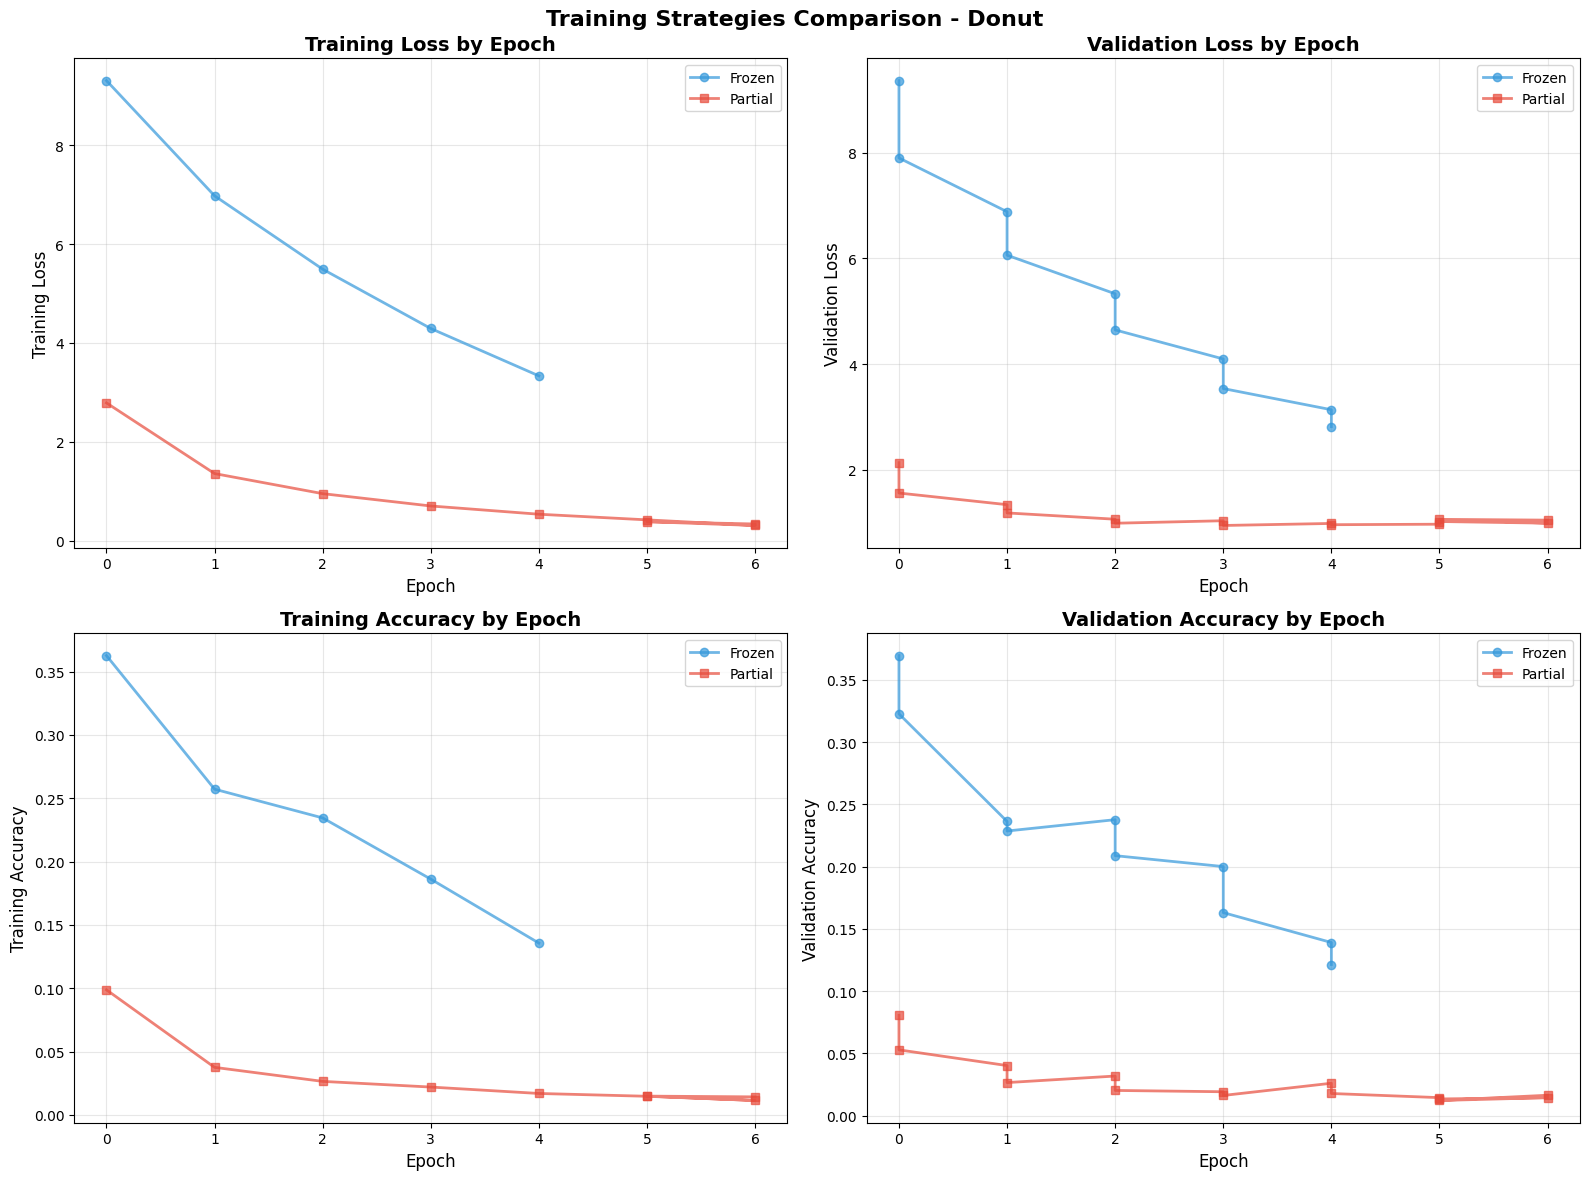

Graphs generated successfully


In [13]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Training Strategies Comparison - Donut', fontsize=16, fontweight='bold')

colors = {'frozen': '#3498db', 'partial': '#e74c3c', 'full': '#2ecc71'}
markers = {'frozen': 'o', 'partial': 's', 'full': '^'}

# Training Loss
ax = axes[0, 0]
for strategy, df in metrics_data.items():
    epoch_data = df[df['train_loss_epoch'].notna()]
    if len(epoch_data) > 0:
        ax.plot(epoch_data['epoch'], epoch_data['train_loss_epoch'], 
               label=strategy.capitalize(), color=colors[strategy], 
               marker=markers[strategy], linewidth=2, markersize=6, alpha=0.7)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Training Loss', fontsize=12)
ax.set_title('Training Loss by Epoch', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Validation Loss
ax = axes[0, 1]
for strategy, df in metrics_data.items():
    epoch_data = df[df['val_loss'].notna()]
    if len(epoch_data) > 0:
        ax.plot(epoch_data['epoch'], epoch_data['val_loss'], 
               label=strategy.capitalize(), color=colors[strategy], 
               marker=markers[strategy], linewidth=2, markersize=6, alpha=0.7)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Validation Loss', fontsize=12)
ax.set_title('Validation Loss by Epoch', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Training Accuracy
ax = axes[1, 0]
for strategy, df in metrics_data.items():
    epoch_data = df[df['train_acc'].notna()]
    if len(epoch_data) > 0:
        ax.plot(epoch_data['epoch'], epoch_data['train_acc'], 
               label=strategy.capitalize(), color=colors[strategy], 
               marker=markers[strategy], linewidth=2, markersize=6, alpha=0.7)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Training Accuracy', fontsize=12)
ax.set_title('Training Accuracy by Epoch', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Validation Accuracy
ax = axes[1, 1]
for strategy, df in metrics_data.items():
    epoch_data = df[df['val_acc'].notna()]
    if len(epoch_data) > 0:
        ax.plot(epoch_data['epoch'], epoch_data['val_acc'], 
               label=strategy.capitalize(), color=colors[strategy], 
               marker=markers[strategy], linewidth=2, markersize=6, alpha=0.7)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Validation Accuracy', fontsize=12)
ax.set_title('Validation Accuracy by Epoch', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Graphs generated successfully")

In [15]:
print("Final Comparison Table")

comparison_data = []

for strategy, df in metrics_data.items():
    epoch_data = df[df['epoch'].notna()]
    
    if len(epoch_data) > 0:
        row = {
            'Strategy': strategy.capitalize(),
            'Epochs': len(epoch_data),
            'Best Val Loss': epoch_data['val_loss'].min() if 'val_loss' in epoch_data.columns else None,
            'Best Val Acc': epoch_data['val_acc'].max() if 'val_acc' in epoch_data.columns else None,
            'Final Train Loss': epoch_data.iloc[-1]['train_loss_epoch'] if 'train_loss_epoch' in epoch_data.columns else None,
            'Final Val Loss': epoch_data.iloc[-1]['val_loss'] if 'val_loss' in epoch_data.columns else None
        }
        comparison_data.append(row)

comparison_df = pd.DataFrame(comparison_data)

# Configure pandas format for better visualization
pd.set_option('display.float_format', lambda x: f'{x:.4f}')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# Display table with pandas
display(comparison_df)

Final Comparison Table


,Strategy,Epochs,Best Val Loss,Best Val Acc,Final Train Loss,Final Val Loss
0,Frozen,28,2.8175,0.3695,NaN,NaN
1,Partial,324,0.9490,0.0806,0.3391,NaN


## Results Analysis

Based on the training results from the first two strategies, we can observe the following:

**Strategy 1: Frozen Encoder**
- Best validation loss: 2.8175 (epoch 4)
- Best validation accuracy: 0.3695 (epoch 0)
- The model shows extremely poor performance with validation accuracy dropping significantly after the first epoch
- Training became unstable after epoch 5, resulting in NaN values
- The frozen encoder approach is insufficient for this task, indicating that the pre-trained Swin Transformer features don't transfer well to receipt-specific document understanding without adaptation

**Strategy 2: Partial Unfreezing**
- Best validation loss: 0.9490 (epoch 3)
- Best validation accuracy: 0.0806 (epoch 0)
- Despite unfreezing the last 2 encoder layers, performance remains very poor
- Validation accuracy is even worse than the frozen strategy, suggesting training instability
- The model completed more epochs but shows signs of divergence with NaN values appearing later in training
- The low accuracy (8% at best) indicates the model is essentially failing to learn the task

Based on these results, we can say:
1. **Both strategies failed**: Neither approach achieved a decent performance for receipt information extraction
2. **Training instability**: Both models experienced NaN losses during training, which may indicate us that the gradient exploded or numerical instability
3. **Poor token prediction**: Having accuracies below 40% tells us that the model cannot reliably predict JSON tokens
4. **Domain mismatch**: The pre-trained Donut model struggles with the specific characteristics of our receipt dataset

Because of the very poor performance from Strategy 1 and 2, we decided to not continue and train Strategy 3, since it requires more computational resources and training time because it is full fine-tuned and required all parameters. Also, due to the fact that the issues observed indicated us that unfreezing more layers wasn´t going to solve the core problem of the training instability and other issues found, mentioned above.

This bad results could be due to numerous resons, like:
- Our dataset size for training has 800 receipts, which might be insufficient for fine-tuning such a large model
- The simplified JSON extraction, which is concatenating all text into a single "text" field, may be too basic for Donut's architecture
- Hyperparameters like learning rate or gradient clipping may need adjustment for this specific dataset

## Conclusion

After implementing and evaluating multiple fine-tuning strategies for the Donut (Document Understanding Transformer) model on receipt information extraction, the results clearly demonstrate that this approach is unsuitable for our specific task and dataset constraints. Both implemented strategies failed catastrophically:

- **Strategy 1 (Frozen Encoder)**: 36.95% validation accuracy, at epoch 0, but training rapidly decreased and collapsed at epoch 5 with NaN losses
- **Strategy 2 (Partial Unfreezing)**: 8.06% validation accuracy, again at epoch 0, but same thing occurred, it rapidly decreased. It was even worse than full frozen encoder, despite unfreezing last two encoder layers
- **Strategy 3 (Full Fine-Tuning)**: Not trained after observing systematic failures

### Root Causes of Failure

1. **Data Representation Mismatch**: Our simplified `{"text": "..."}` format eliminated the structure Donut requires, which is a structured key-value pairs (`menu.name`, `menu.price`, `total.total_price`), not flattened text.
2. **Insufficient Dataset**: 800 receipts is very small for fine-tuning a 149M parameter vision-language model.
3. **Training Instability**: NaN losses indicate gradient explosion in autoregressive generation, likely from hyperparameter mismatch.
4. **Overly Ambitious Scope**: Full structured extraction proved too complex. Using field-specific models would enable more focused learning.

### Critical Lessons Learned

1. **Match complexity to dataset**: 800 samples works for single-field extraction, not more complicated field structured output
2. **Alignment is mandatory**: Model architecture must perfectly match training data structure
3. **Start simple**: Build specialized extractors first, validate, then expand
4. **Pivot quickly**: NaN losses by epoch 5 demand immediate strategy change
5. **Measure correctly**: Token accuracy ≠ JSON validity or field extraction accuracy

### Final Conclusions

For receipt extraction with 800 samples, Donut is not suitable. Simple, well-designed pipelines like docTR, outperform complex  models when:
- Data is limited (< 5K samples)
- Task scope is narrow and well-defined
- Production demands reliability over sophistication

**Key Takeaway**: A working specialized solution is infinitely more valuable than a failing general one. Choose the simplest architecture that solves your problem, not the most impressive one.